# Do Red Cards Lead to More Overall Goals? --- Football Radar Assessment ---
By **Sahil Bharti**

This notebook performs exploratory data analysis (EDA) and a causal analysis to assess whether red cards lead to *more total goals* in a match.

**NOTE:** Please note that this notebook contains raw code. All the interpretations and analysis is present in the report.

## **Libraries & Modeling Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.stats.sandwich_covariance import cov_cluster
from scipy.stats import t
from sklearn.linear_model import LinearRegression

## **Load Data & Initial Checks**

In [2]:
events = pd.read_csv("/Users/sahilbharti/Downloads/events.csv")
games  = pd.read_csv("/Users/sahilbharti/Downloads/games.csv")

# Normalize column names to lower snake-case so merges/filters are consistent.
events.columns = [c.strip().lower() for c in events.columns]
games.columns  = [c.strip().lower() for c in games.columns]

print("Event types:", events['type'].value_counts().to_dict())
print("Minute range:", (events['minute'].min(), events['minute'].max()))
print("\nGames columns:", games.columns.tolist())

Event types: {'goal': 54019, 'red_card': 3731}
Minute range: (1, 90)

Games columns: ['game_id', 'home_team', 'away_team', 'competition', 'date', 'home_goals', 'away_goals']


## **Per-Game Summary & Sanity Checks**

In [3]:
# Build per-game summary
games = games.copy()

# Official total goals from the match record (ground truth target)
games['total_goals_official'] = games['home_goals'] + games['away_goals']

# Split events into goals and red cards
goals = events[events['type']=='goal'][['game_id','minute','side']].copy()
reds  = events[events['type']=='red_card'][['game_id','minute','side']].copy()

# Count how many goal events per game
goals_per_game = goals.groupby('game_id').size().rename('goals_events').reset_index()

# First red card minute per game
first_red = reds.groupby('game_id')['minute'].min().rename('first_red_minute').reset_index()

# Number of red cards per game
red_count = reds.groupby('game_id').size().rename('n_reds').reset_index()

# Join everything onto the game table
summary = (games
    .merge(goals_per_game, on='game_id', how='left')
    .merge(first_red,      on='game_id', how='left')
    .merge(red_count,      on='game_id', how='left')
)

# Fill NAs for games with no goals/no reds, and derive a flag
summary['goals_events'] = summary['goals_events'].fillna(0).astype(int)
summary['n_reds'] = summary['n_reds'].fillna(0).astype(int)
summary['any_red'] = (summary['n_reds'] > 0).astype(int)

# Sanity check
mismatch = (summary['goals_events'] != summary['total_goals_official']).sum()
print("Sanity — events match official goal totals:", mismatch == 0)
print("Total games:", len(summary), "| with ≥1 red:", int((summary['any_red']==1).sum()))

Sanity — events match official goal totals: True
Total games: 20370 | with ≥1 red: 3273


## **Core Helpers: Minute-wise Goal Arrays, Time Bins & Pre/Post Split**

In [4]:
MAX_MIN = 90

# For each game, collect a list of minutes where goals occurred
goal_minutes = goals.groupby('game_id')['minute'].apply(list).to_dict()

def goals_array(min_list):
    """
    Converts a list of goal minutes into a fixed-size array of length 91.
    """
    arr = np.zeros(MAX_MIN + 1, dtype=int)  
    for m in min_list:
        if 1 <= m <= MAX_MIN:
            arr[m] += 1  # supports multiple goals in same minute, if any
    return arr

game_goal_arrays = {gid: goals_array(goal_minutes.get(gid, [])) for gid in summary['game_id']}

BINS = [(1,15),(16,30),(31,45),(46,60),(61,75),(76,90)]

def minute_bin(m):
    """
    Map a minute (int-like) to a labeled 15-min bin, e.g., 1..15 -> '01-15'.
    """
    for (a, b) in BINS:
        if a <= int(m) <= b:
            return f"{a:02d}-{b:02d}"
    return None

def pre_post_at_m(gid, m):
    """
    Return (pre_goals, post_goals) when splitting at minute m.
    PRE includes minute m; POST starts at m+1. (Copes with 45/90 capping.)
    """
    m = int(m)
    arr = game_goal_arrays[gid]
    pre  = arr[:m+1].sum()
    post = arr[m+1:].sum()
    return pre, post

# Treated set with clean first red minute
treated = summary[summary['any_red']==1].dropna(subset=['first_red_minute']).copy()
treated['first_red_minute'] = treated['first_red_minute'].astype(int)

In [5]:
# Compute pre_goals_at_m and pre_bin classification for treated matches
# Categorise the number of goals scored before the red card (0,1,2+)

treated = treated.copy()
treated['pre_goals_at_m'] = [game_goal_arrays[int(gid)][1:int(m)+1].sum() for gid, m in zip(treated['game_id'], treated['first_red_minute'])]

def prebin(x):
    """
    Coarsened pre-state used for stratification/matching.
    """
    if x == 0:  return '0'
    if x == 1:  return '1'
    return '2+'

treated['pre_bin'] = treated['pre_goals_at_m'].apply(prebin)

# Define a DataFrame of no-red matches for convenience
no_red = summary[summary['any_red']==0].copy()

## **Baseline (Naive) Full-Match Comparison: Red-Card vs No-Red Games**

In [6]:
y_red = summary.loc[summary['any_red']==1, 'total_goals_official'].astype(float)
y_ctl = summary.loc[summary['any_red']==0, 'total_goals_official'].astype(float)

# Group means and sample sizes
mu_red, mu_ctl = y_red.mean(), y_ctl.mean()
sd_red, sd_ctl = y_red.std(ddof=1), y_ctl.std(ddof=1)
n_red, n_ctl = len(y_red), len(y_ctl)

# Difference in means and an approximate 95% CI using the usual large-sample SE.
diff = mu_red - mu_ctl
se_diff = np.sqrt(sd_red**2/n_red + sd_ctl**2/n_ctl)
ci = (diff - 1.96*se_diff, diff + 1.96*se_diff)

print(f"Mean goals - RED: {mu_red:.3f} (n={n_red}) | NO-RED: {mu_ctl:.3f} (n={n_ctl})")
print(f"Difference in means: {diff:.3f}  (95% CI {ci[0]:.3f}, {ci[1]:.3f})")

Mean goals - RED: 2.695 (n=3273) | NO-RED: 2.644 (n=17097)
Difference in means: 0.051  (95% CI -0.010, 0.113)


## **Difference-in-differences (DiD) analysis for goal rates**

In [7]:
def load_and_prepare_data(events_df=None, games_df=None):
    # Use preloaded dataframes if not passed in
    if events_df is None:
        events_df = events
    if games_df is None:
        games_df = games

    red_cards = events_df[events_df['type'] == 'red_card'].copy()
    goals     = events_df[events_df['type'] == 'goal'].copy()

    # First red minute per game
    first_red = (
        red_cards.groupby('game_id')['minute']
                 .min()
                 .reset_index()
                 .rename(columns={'minute': 'red_card_minute'})
    )

    # Attach first red minute & an indicator to the games table
    games_enhanced = games_df.merge(first_red, on='game_id', how='left')
    games_enhanced['has_red_card'] = games_enhanced['red_card_minute'].notna()

    return games_enhanced, goals


def create_diff_in_diff_dataset(games_enhanced, goals):
    """
    Build a per-game dataset for DiD:
      - For treated games: use the observed first red minute.
      - For controls: sample a "fake" red minute from the treated distribution
        so that pre/post exposure windows are comparable.
      - Compute pre/post counts AND pre/post rates (goals per minute).
    """
    # Distribution of observed red minutes among treated (used to simulate control timings)
    red_card_minutes = (
        games_enhanced.loc[games_enhanced['has_red_card'], 'red_card_minute']
                      .dropna()
                      .values
    )

    results = []
    for _, game in games_enhanced.iterrows():
        game_id = game['game_id']
        has_red = bool(game['has_red_card'])

        # All goal events in this game
        game_goals = goals[goals['game_id'] == game_id].copy()

        if has_red:
            red_minute = int(game['red_card_minute'])
            treatment  = 1
        else:
            # Tie each control's fake red to its game_id for deterministic results
            np.random.seed(int(game_id))
            red_minute = int(np.random.choice(red_card_minutes))
            treatment  = 0

        # Exposure windows (cap at 90 as per dataset convention)
        minutes_before = min(red_minute, 90)
        minutes_after  = max(0, 90 - red_minute)

        # Only compute if both sides have non-zero exposure
        if minutes_before > 0 and minutes_after > 0:
            # PRE includes minute m; POST begins at m+1
            goals_before = int((game_goals['minute'] <= red_minute).sum())
            goals_after  = int((game_goals['minute'] >  red_minute).sum())

            rate_before = goals_before / minutes_before
            rate_after  = goals_after  / minutes_after if minutes_after > 0 else 0.0

            results.append({
                'game_id':        game_id,
                'treatment':      treatment,      
                'red_minute':     red_minute,     
                'goals_before':   goals_before,
                'goals_after':    goals_after,
                'minutes_before': minutes_before,
                'minutes_after':  minutes_after,
                'rate_before':    rate_before,
                'rate_after':     rate_after,
                'rate_change':    rate_after - rate_before
            })

    return pd.DataFrame(results)


def regression_based_did_analysis(data):
    """
    Run a simple regression-based DiD on minute-aligned pre/post *rates*.
    """
    # Stack pre and post into separate rows for each game
    reg_rows = []
    for _, row in data.iterrows():
        reg_rows += [
            {'game_id': row['game_id'], 'period': 0, 'treatment': row['treatment'],
             'goal_rate': row['rate_before'], 'minutes': row['minutes_before'], 'red_minute': row['red_minute']},
            {'game_id': row['game_id'], 'period': 1, 'treatment': row['treatment'],
             'goal_rate': row['rate_after'],  'minutes': row['minutes_after'],  'red_minute': row['red_minute']},
        ]
    reg_df = pd.DataFrame(reg_rows)

    # DiD interaction
    reg_df['treat_x_post'] = reg_df['treatment'] * reg_df['period']

    # Simple controls
    reg_df['log_minutes'] = np.log(reg_df['minutes'] + 1)  # stabilize variance for very short windows
    red_mean, red_std = reg_df['red_minute'].mean(), reg_df['red_minute'].std()
    reg_df['red_minute_norm'] = (reg_df['red_minute'] - red_mean) / (red_std if red_std > 0 else 1.0)

    # Design matrix and target
    X = reg_df[['treatment', 'period', 'treat_x_post', 'log_minutes', 'red_minute_norm']].values
    y = reg_df['goal_rate'].values

    # Drop any rows with non-finite values (defensive)
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
    X, y = X[mask], y[mask]

    # OLS via sklearn 
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred

    # Manual OLS standard errors
    n, k = X.shape
    mse = np.sum(residuals**2) / (n - k)
    XtX_inv = np.linalg.inv(X.T @ X)
    se_coef = np.sqrt(np.diag(XtX_inv * mse))

    # The DiD effect is the coefficient on treatxpost
    did_coef = float(model.coef_[2])
    did_se   = float(se_coef[2])

    # t-stat and two-sided p-value (using Student-t with n-k dof)
    t_stat = did_coef / did_se if did_se > 0 else np.nan
    p_val  = 2 * (1 - t.cdf(abs(t_stat), n - k)) if did_se > 0 else np.nan

    # Express the effect relative to the treated baseline pre-rate (interpretability)
    baseline = reg_df[(reg_df['treatment'] == 1) & (reg_df['period'] == 0)]['goal_rate'].mean()
    pct_inc = (did_coef / baseline) * 100 if baseline and baseline > 0 else np.nan

    return {
        'did_coefficient':    did_coef,        # goals per minute
        'standard_error':     did_se,
        't_statistic':        t_stat,
        'p_value':            p_val,
        'percentage_increase': pct_inc,        # relative to treated pre-rate
        'baseline_rate':      float(baseline) if baseline == baseline else np.nan
    }


def run_regression_did():
    games_enhanced, goals = load_and_prepare_data()
    dd_data = create_diff_in_diff_dataset(games_enhanced, goals)
    res     = regression_based_did_analysis(dd_data)

    print('=' * 50)
    print('Regression-based DiD Results')
    print('=' * 50)
    if np.isfinite(res['percentage_increase']):
        print(f"Treatment Effect: {res['percentage_increase']:.1f}% increase in goal rate")
    else:
        print("Treatment Effect: NA% (baseline rate is zero)")
    print(f"Statistical Significance: p = {res['p_value']:.3f}")
    print(f"DiD Coefficient: {res['did_coefficient']:.6f} goals per minute")
    print(f"Standard Error: {res['standard_error']:.6f}")
    print(f"Baseline goal rate: {res['baseline_rate']:.6f} goals/minute")

    return res
    
res_did = run_regression_did()

Regression-based DiD Results
Treatment Effect: 22.7% increase in goal rate
Statistical Significance: p = 0.002
DiD Coefficient: 0.005870 goals per minute
Standard Error: 0.001913
Baseline goal rate: 0.025834 goals/minute


## **Exposure-Adjusted Goals/Minute Before vs After First Red Card**

In [8]:
pre_goals_total = pre_exp_total = post_goals_total = post_exp_total = 0


for gid, m in zip(treated['game_id'], treated['first_red_minute']):
    # Use helper that splits at m: PRE includes m; POST starts at m+1
    pre, post = pre_post_at_m(gid, m)
    pre_goals_total  += pre
    post_goals_total += post
    # Exposure = minutes observed on each side of the split
    pre_exp_total  += max(0, m - 1)
    post_exp_total += max(0, MAX_MIN - m)

# Goals per minute before vs after (treated only)
rate_pre  = pre_goals_total  / pre_exp_total  if pre_exp_total  > 0 else np.nan
rate_post = post_goals_total / post_exp_total if post_exp_total > 0 else np.nan
uplift = rate_post - rate_pre
pct = (uplift / rate_pre * 100) if rate_pre>0 else np.nan

print(f"Goals/min BEFORE: {rate_pre:.4f} | AFTER: {rate_post:.4f} | Δ = {uplift:.4f} ({pct:.1f}%)")

Goals/min BEFORE: 0.0273 | AFTER: 0.0372 | Δ = 0.0099 (36.3%)


## **EDA:**

### 1. Distribution of Total Goals per Match

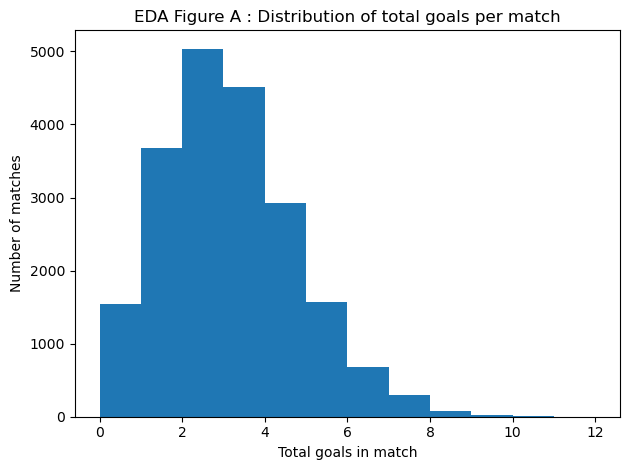

In [9]:
vals = summary['total_goals_official'].values
plt.figure()
plt.hist(vals, bins=range(int(vals.min()), int(vals.max())+2))
plt.xlabel('Total goals in match')
plt.ylabel('Number of matches')
plt.title('EDA Figure A : Distribution of total goals per match')
plt.tight_layout()
plt.show()

### 2. First Red-Card Timing

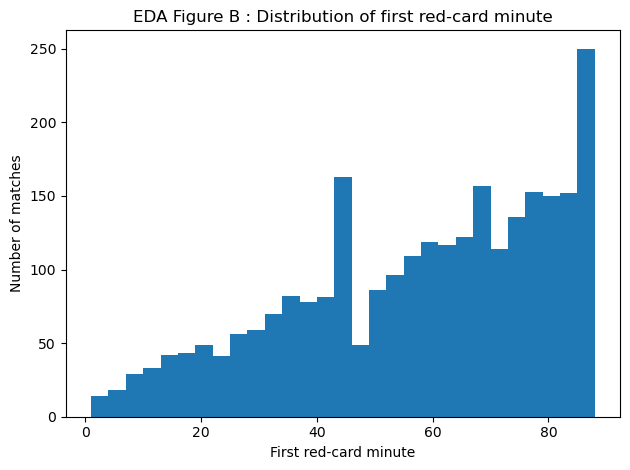

In [10]:
red_times = treated['first_red_minute'].values
plt.figure()
plt.hist(red_times, bins=list(range(1, 91, 3)))
plt.xlabel('First red-card minute')
plt.ylabel('Number of matches')
plt.title('EDA Figure B : Distribution of first red-card minute')
plt.tight_layout()
plt.show()

### 3. Reds per Match (Count Distribution)

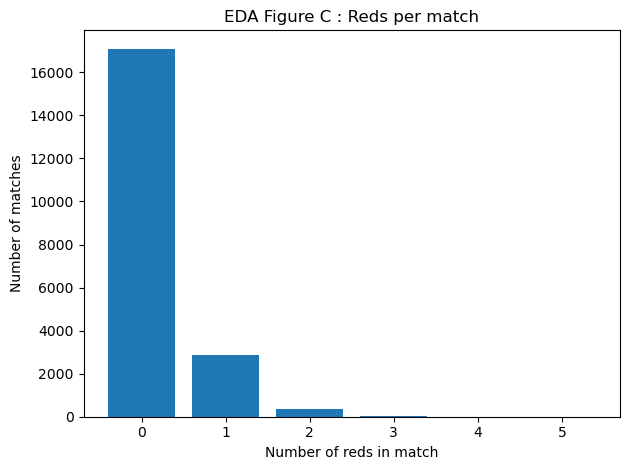

In [11]:
counts = summary['n_reds'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Number of reds in match')
plt.ylabel('Number of matches')
plt.title('EDA Figure C : Reds per match')
plt.tight_layout()
plt.show()

### 4. Minute-by-Minute Scoring Profile : Red-Card vs No-Red Matches

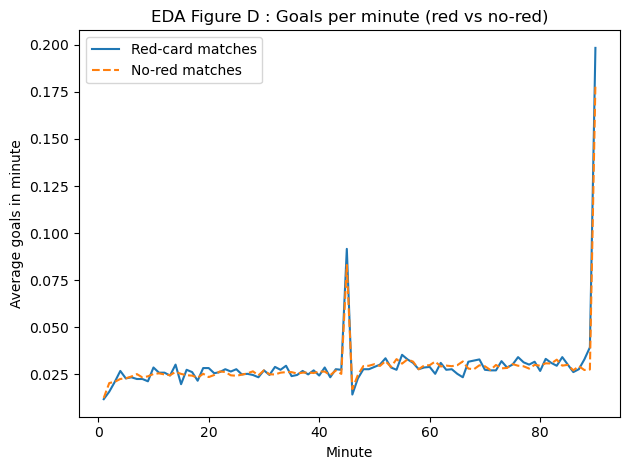

In [12]:
red_ids = summary[summary['any_red']==1]['game_id'].values
no_red_ids = summary[summary['any_red']==0]['game_id'].values
A_red = np.stack([game_goal_arrays[g] for g in red_ids], axis=0) if len(red_ids)>0 else np.zeros((0, MAX_MIN+1))
A_nrd = np.stack([game_goal_arrays[g] for g in no_red_ids], axis=0) if len(no_red_ids)>0 else np.zeros((0, MAX_MIN+1))

avg_red = A_red.mean(axis=0) if A_red.size>0 else np.zeros(MAX_MIN+1)
avg_nrd = A_nrd.mean(axis=0) if A_nrd.size>0 else np.zeros(MAX_MIN+1)

mins = np.arange(1, MAX_MIN+1)
plt.figure()
plt.plot(mins, avg_red[1:], label='Red-card matches')
plt.plot(mins, avg_nrd[1:], label='No-red matches', linestyle='--')
plt.xlabel('Minute')
plt.ylabel('Average goals in minute')
plt.title('EDA Figure D : Goals per minute (red vs no-red)')
plt.legend()
plt.tight_layout()
plt.show()

### 5. Cumulative Goals by Minute : Red-Card vs No-Red Matches

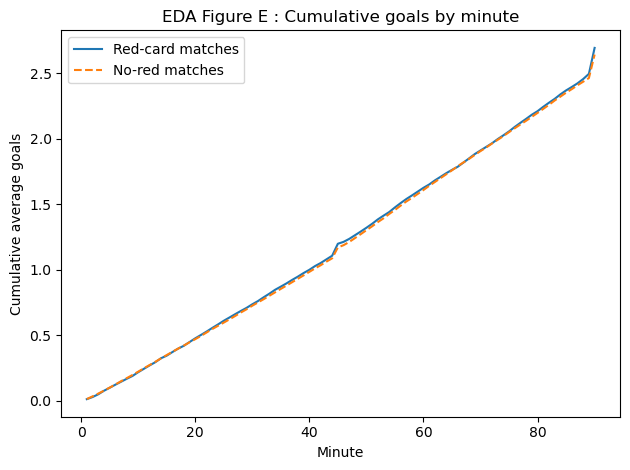

In [13]:
cum_red = np.cumsum(avg_red)
cum_nrd = np.cumsum(avg_nrd)
plt.figure()
plt.plot(mins, cum_red[1:], label='Red-card matches')
plt.plot(mins, cum_nrd[1:], label='No-red matches', linestyle='--')
plt.xlabel('Minute')
plt.ylabel('Cumulative average goals')
plt.title('EDA Figure E : Cumulative goals by minute')
plt.legend()
plt.tight_layout()
plt.show()

### 6. Total Goals vs First Red-Card Timing

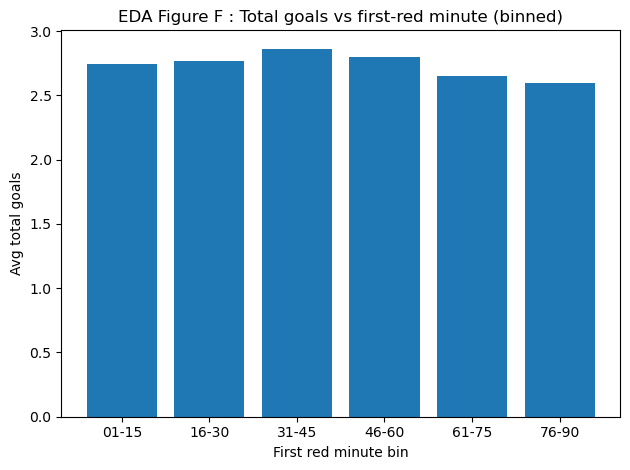

In [14]:
# Ensure totals exist (defensive)
if 'total_goals_official' not in summary.columns:
    summary = summary.copy()
    summary['total_goals_official'] = summary['home_goals'] + summary['away_goals']

# Build a treated copy with per-game totals
treated_copy = (
    treated[['game_id', 'first_red_minute']].copy()
    .merge(summary[['game_id','total_goals_official']], on='game_id', how='left')
)

# If for any reason the merge left NaNs, recompute from games as a fallback
if treated_copy['total_goals_official'].isna().any():
    treated_copy = treated_copy.merge(
        games[['game_id','home_goals','away_goals']],
        on='game_id', how='left'
    )
    treated_copy['total_goals_official'] = treated_copy['total_goals_official'].fillna(
        treated_copy['home_goals'] + treated_copy['away_goals']
    )

# Bin by first red minute
treated_copy['bin'] = treated_copy['first_red_minute'].astype(int).apply(minute_bin)

# Compute means in a fixed order
order = ['01-15','16-30','31-45','46-60','61-75','76-90']
bin_means = (treated_copy
             .groupby('bin', as_index=True)['total_goals_official']
             .mean()
             .reindex(order))

# Plot
plt.figure()
plt.bar(bin_means.index, bin_means.values)
plt.xlabel('First red minute bin')
plt.ylabel('Avg total goals')
plt.title('EDA Figure F : Total goals vs first-red minute (binned)')
plt.tight_layout()
plt.show()

## **ATT: Post-Minute Goals (Matched by Minute & Pre-Goals)**

In [15]:
# Cache to avoid recomputation across many treated rows
post_cache = {}

def control_post_avg_for_m(m, prebin):
    key = ('post', int(m), prebin)
    if key in post_cache:
        return post_cache[key]
    post_vals = []
    for gid in no_red['game_id'].values:
        arr = game_goal_arrays[int(gid)]
        pre_c  = arr[1:m].sum()
        if   prebin == "0" and pre_c != 0:  continue
        elif prebin == "1" and pre_c != 1:  continue
        elif prebin == "2+" and pre_c < 2:  continue
        post_c = arr[m+1:91].sum()
        post_vals.append(post_c)
    val = float(np.mean(post_vals)) if len(post_vals)>0 else np.nan
    post_cache[key] = val
    return val

treated = treated.copy()
treated['post_goals_after_m'] = [game_goal_arrays[int(gid)][m+1:91].sum() for gid, m in zip(treated['game_id'], treated['first_red_minute'])]
treated['control_post_avg']   = [control_post_avg_for_m(m, pb) for m, pb in zip(treated['first_red_minute'], treated['pre_bin'])]

# ATT contribution per treated match
treated['att_post_goals']     = treated['post_goals_after_m'] - treated['control_post_avg']

# Overall ATT and 95% CI (large-sample normal approximation)
att = treated['att_post_goals'].dropna().values
att_mean = float(np.mean(att))
att_se   = float(np.std(att, ddof=1)/np.sqrt(len(att)))
att_ci   = (att_mean - 1.96*att_se, att_mean + 1.96*att_se)

print(f"ATT overall (post-minute): {att_mean:.3f}  (95% CI {att_ci[0]:.3f}, {att_ci[1]:.3f}); N={len(att)}")

ATT overall (post-minute): 0.083  (95% CI 0.051, 0.116); N=3273


### **ATT by First-Red Timing (15-min bins)**

In [16]:
# Heterogeneity by timing of the first red
treated['minute_bin'] = treated['first_red_minute'].apply(minute_bin)
grp = treated.groupby('minute_bin')['att_post_goals']

# 'count' = number of treated games in the bin; 'att_mean' = mean ATT in bin
att_by_bin = grp.agg(['count','mean']).reset_index().rename(columns={'mean':'att_mean'})

# Bin-wise standard error for 95% CI bars
att_se_by_bin = grp.apply(lambda x: np.std(x.dropna(), ddof=1)/np.sqrt(len(x.dropna()))).reset_index(name='att_se')
att_table = att_by_bin.merge(att_se_by_bin, on='minute_bin', how='left')
att_table

,minute_bin,count,att_mean,att_se
0,01-15,136,0.161908,0.148571
1,16-30,248,0.117621,0.083640
2,31-45,474,0.161868,0.061338
3,46-60,459,0.109635,0.048625
4,61-75,646,0.099253,0.035527
5,76-90,1310,0.023306,0.012587


### **ATT by First-Red Timing - 95% CI Plot**

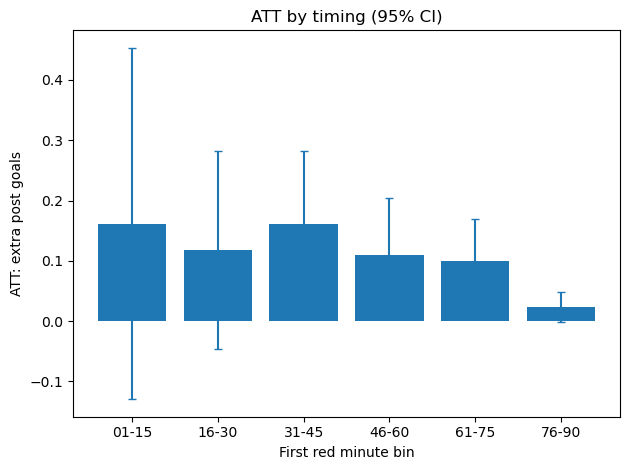

In [17]:
# Plot ATT by timing bin with 95% CI
order = ['01-15','16-30','31-45','46-60','61-75','76-90']
plot_df = att_table.set_index('minute_bin').reindex(order).reset_index()

plt.figure()
plt.bar(plot_df['minute_bin'], plot_df['att_mean'])
plt.errorbar(plot_df['minute_bin'], plot_df['att_mean'], yerr=1.96*plot_df['att_se'], fmt='none', capsize=3)
plt.xlabel('First red minute bin'); plt.ylabel('ATT: extra post goals')
plt.title('ATT by timing (95% CI)')
plt.tight_layout(); plt.show()

### **Placebo Test: ATT Null Distribution**

Placebo mean: 0.022 Placebo SE: 0.013 | Actual ATT: 0.083


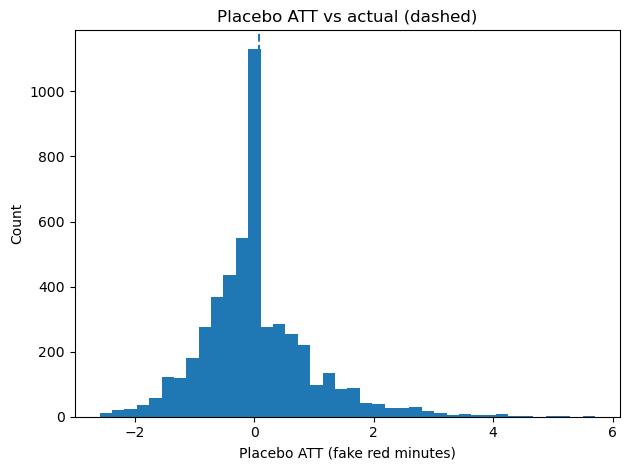

In [18]:
rng = np.random.default_rng(7)
red_min_dist = treated['first_red_minute'].values
no_red_games = summary[summary['any_red']==0]['game_id'].values

placebos = []
sample_ids = no_red_games[:5000]  # subsample for speed
for gid in sample_ids:
    m_fake = int(rng.choice(red_min_dist))
    arr = game_goal_arrays[int(gid)]
    pre = arr[1:m_fake].sum()
    post = arr[m_fake+1:91].sum()
    pb = "0" if pre==0 else ("1" if pre==1 else "2+")
    ckey = ('post', m_fake, pb)
    if ckey not in post_cache:
        post_cache[ckey] = control_post_avg_for_m(m_fake, pb)
    placebos.append(post - post_cache[ckey])

placebos = np.array(placebos, dtype=float)
placebo_mean = float(np.nanmean(placebos))
placebo_se   = float(np.nanstd(placebos, ddof=1)/np.sqrt(np.sum(~np.isnan(placebos))))
print("Placebo mean:", round(placebo_mean,3), "Placebo SE:", round(placebo_se,3), "| Actual ATT:", round(att_mean,3))

plt.figure()
plt.hist(placebos[~np.isnan(placebos)], bins=40)
plt.axvline(att_mean, linestyle='--')
plt.xlabel('Placebo ATT (fake red minutes)'); plt.ylabel('Count')
plt.title('Placebo ATT vs actual (dashed)')
plt.tight_layout(); plt.show()

### **Placebo ATT (Fake Red Minutes) : Build & Plot**

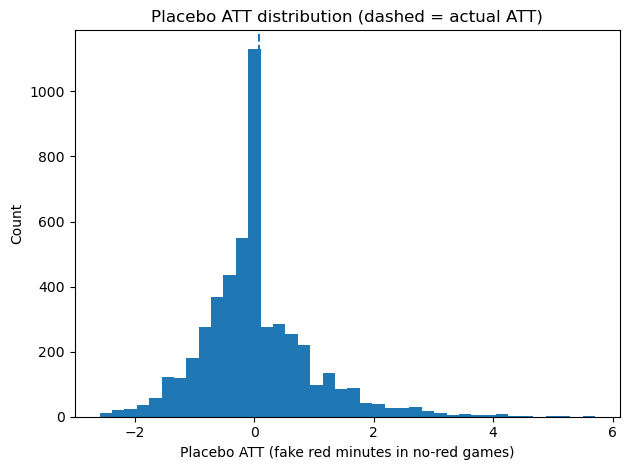

In [19]:
plt.figure()
plt.hist(placebos[~np.isnan(placebos)], bins=40)
plt.axvline(att_mean, linestyle='--')
plt.xlabel('Placebo ATT (fake red minutes in no-red games)')
plt.ylabel('Count')
plt.title('Placebo ATT distribution (dashed = actual ATT)')
plt.tight_layout()
plt.show()

### **Robustness Checks: Sensitivity Table (ATT & 95% CI)**

In [20]:
# Exclude 45/90
treated_ex = treated[~treated['first_red_minute'].isin([45,90])].copy()
att_ex = (treated_ex['post_goals_after_m'] - treated_ex['control_post_avg']).dropna().values
att_ex_mean = float(np.mean(att_ex))
att_ex_se   = float(np.std(att_ex, ddof=1)/np.sqrt(len(att_ex)))

# One-red only
one_red_ids = summary[summary['n_reds']==1]['game_id'].values
treated_one = treated[treated['game_id'].isin(one_red_ids)].copy()
att_one = (treated_one['post_goals_after_m'] - treated_one['control_post_avg']).dropna().values
att_one_mean = float(np.mean(att_one))
att_one_se   = float(np.std(att_one, ddof=1)/np.sqrt(len(att_one)))

sens_table = pd.DataFrame({
    'specification': ['Overall ATT','Exclude 45/90','One red only'],
    'att_mean': [att_mean, att_ex_mean, att_one_mean],
    'att_se':   [att_se,   att_ex_se,   att_one_se],
})
sens_table['ci_low']  = sens_table['att_mean'] - 1.96*sens_table['att_se']
sens_table['ci_high'] = sens_table['att_mean'] + 1.96*sens_table['att_se']
sens_table

,specification,att_mean,att_se,ci_low,ci_high
0,Overall ATT,0.083375,0.016685,0.050673,0.116077
1,Exclude 45/90,0.091157,0.020145,0.051672,0.130642
2,One red only,0.080724,0.017336,0.046746,0.114702


### **GLM-NB: Pre vs Post Red (Rate Ratio, Exposure Offset, Clustered SEs)**

In [21]:
# Build segments (pre/post for red games; full 90 for no-red)
segments = []
for _, row in summary.iterrows():
    gid = int(row['game_id']); comp = row['competition']; m = row['first_red_minute']
    arr = game_goal_arrays[gid]
    if pd.notnull(m):
        m = int(m)
        pre_exp  = max(0, m-1)
        post_exp = max(0, MAX_MIN - m)
        pre_goals  = arr[1:m].sum()    if pre_exp>0  else 0
        post_goals = arr[m+1:91].sum() if post_exp>0 else 0
        if pre_exp  > 0: segments.append((gid, comp, 0, pre_goals,  pre_exp))
        if post_exp > 0: segments.append((gid, comp, 1, post_goals, post_exp))
    else:
        segments.append((gid, comp, 0, arr[1:91].sum(), 90))

seg = pd.DataFrame(segments, columns=['game_id','competition','red_segment','goals','exposure'])
seg = seg[seg['exposure']>0].copy()

comp_dum = pd.get_dummies(seg['competition'], prefix='comp', drop_first=True, dtype=float)
X_seg = pd.concat([pd.DataFrame({'red_segment': seg['red_segment'].astype(float)}), comp_dum], axis=1).astype(float)
X_seg = add_constant(X_seg, has_constant='add')
y_seg = seg['goals'].astype(float)
offset = np.log(seg['exposure'].astype(float))

# 1) Estimate alpha via discrete NB2
nb_disc = sm.NegativeBinomial(y_seg, X_seg, loglike_method='nb2', offset=offset).fit(disp=False, maxiter=200)
try:
    alpha_hat = float(nb_disc.params['alpha'])
except Exception:
    alpha_hat = float(nb_disc.model._get_alpha(nb_disc.params))
print(f"Estimated NB alpha: {alpha_hat:.4f}")

# 2) GLM NB with fixed alpha + clustered SEs
nb_glm = sm.GLM(y_seg, X_seg, family=sm.families.NegativeBinomial(alpha=alpha_hat), offset=offset)
nb_glm_res = nb_glm.fit(cov_type='cluster', cov_kwds={'groups': seg['game_id']})

beta = nb_glm_res.params['red_segment']; se = nb_glm_res.bse['red_segment']
rr   = float(np.exp(beta))
rr_ci= (float(np.exp(beta - 1.96*se)), float(np.exp(beta + 1.96*se)))

nb_table = pd.DataFrame({
    'parameter': ['rate_ratio_red_segment'],
    'estimate':  [rr],
    'ci_low':    [rr_ci[0]],
    'ci_high':   [rr_ci[1]]
})
nb_table

Estimated NB alpha: 0.0000


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


,parameter,estimate,ci_low,ci_high
0,rate_ratio_red_segment,1.291934,1.248585,1.336787


## **Results Summary: Consolidated Estimates (ATT, Bin-wise, Placebo, Sensitivity, NB)**

In [22]:
summary_rows = []

# Overall ATT
summary_rows.append({'metric':'ATT overall (post-minute)','estimate':att_mean,'ci_low':att_ci[0],'ci_high':att_ci[1],'notes':f'N={len(att)}'})

# ATT by timing bins
for _, r in att_table.iterrows():
    mbin = r['minute_bin']
    summary_rows.append({
        'metric':f'ATT by bin: {mbin}',
        'estimate':r['att_mean'],
        'ci_low':r['att_mean']-1.96*r['att_se'],
        'ci_high':r['att_mean']+1.96*r['att_se'],
        'notes':f"N={int(r['count'])}"
    })

# Placebo
summary_rows.append({
    'metric':'Placebo mean (fake reds)',
    'estimate':placebo_mean,
    'ci_low':placebo_mean-1.96*placebo_se,
    'ci_high':placebo_mean+1.96*placebo_se,
    'notes':'Expected ~0 if design is well-specified'
})

# Sensitivity
summary_rows.append({
    'metric':'ATT excl. 45/90',
    'estimate':sens_table.loc[sens_table['specification']=='Exclude 45/90','att_mean'].item(),
    'ci_low':sens_table.loc[sens_table['specification']=='Exclude 45/90','ci_low'].item(),
    'ci_high':sens_table.loc[sens_table['specification']=='Exclude 45/90','ci_high'].item(),
    'notes':''
})
summary_rows.append({
    'metric':'ATT one-red-only',
    'estimate':sens_table.loc[sens_table['specification']=='One red only','att_mean'].item(),
    'ci_low':sens_table.loc[sens_table['specification']=='One red only','ci_low'].item(),
    'ci_high':sens_table.loc[sens_table['specification']=='One red only','ci_high'].item(),
    'notes':''
})

# NegBin
summary_rows.append({
    'metric':'NB rate ratio (post-red segment)',
    'estimate':nb_table['estimate'].item(),
    'ci_low':nb_table['ci_low'].item(),
    'ci_high':nb_table['ci_high'].item(),
    'notes':'Competition dummies + exposure offset'
})

results_summary = pd.DataFrame(summary_rows)
results_summary

,metric,estimate,ci_low,ci_high,notes
0,ATT overall (post-minute),0.083375,0.050673,0.116077,N=3273
1,ATT by bin: 01-15,0.161908,-0.129292,0.453107,N=136
2,ATT by bin: 16-30,0.117621,-0.046313,0.281555,N=248
3,ATT by bin: 31-45,0.161868,0.041645,0.282091,N=474
4,ATT by bin: 46-60,0.109635,0.014329,0.204940,N=459
5,ATT by bin: 61-75,0.099253,0.029620,0.168886,N=646
6,ATT by bin: 76-90,0.023306,-0.001365,0.047977,N=1310
7,Placebo mean (fake reds),0.021528,-0.004297,0.047354,Expected ~0 if design is well-specified
8,ATT excl. 45/90,0.091157,0.051672,0.130642,
9,ATT one-red-only,0.080724,0.046746,0.114702,
